## Import all libraries ##

In [6]:
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dropout, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, SeparableConv2D, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import threading
import psutil
import os
import time
import numpy as np
import gc
import seaborn as sns
import pprint
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
gc.collect()

78

## Import dataset ##

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
IMAGE_SIZE = (32, 32)

data = []
labels = []

def load_images(folder, label):
    for file in os.listdir(folder):
        if file.lower().endswith((".jpg", ".png", ".jpeg")):
            img_path = os.path.join(folder, file)

            img = Image.open(img_path).convert("RGB")
            img = img.resize(IMAGE_SIZE)

            img_array = np.array(img, dtype="float32") / 255.0
            data.append(img_array)
            labels.append(label)

# Galaxy = 0, Stars = 1
load_images("/content/drive/MyDrive/deep/data/galaxy", label=0)
load_images("/content/drive/MyDrive/deep/data/star", label=1)

X_train = np.array(data)
y_train = np.array(labels)

print("Images shape:", X_train.shape)   # (num_samples, 224, 224, 3)
print("Labels shape:", y_train.shape)   # (num_samples,)


Images shape: (44947, 32, 32, 3)
Labels shape: (44947,)


## Data preprocessing

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.167, random_state=42, shuffle=True )
print('train set :', X_train.shape)
print("y_train:", y_train.shape)
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)

train set : (37440, 32, 32, 3)
y_train: (37440,)
X_val: (7507, 32, 32, 3)
y_val: (7507,)


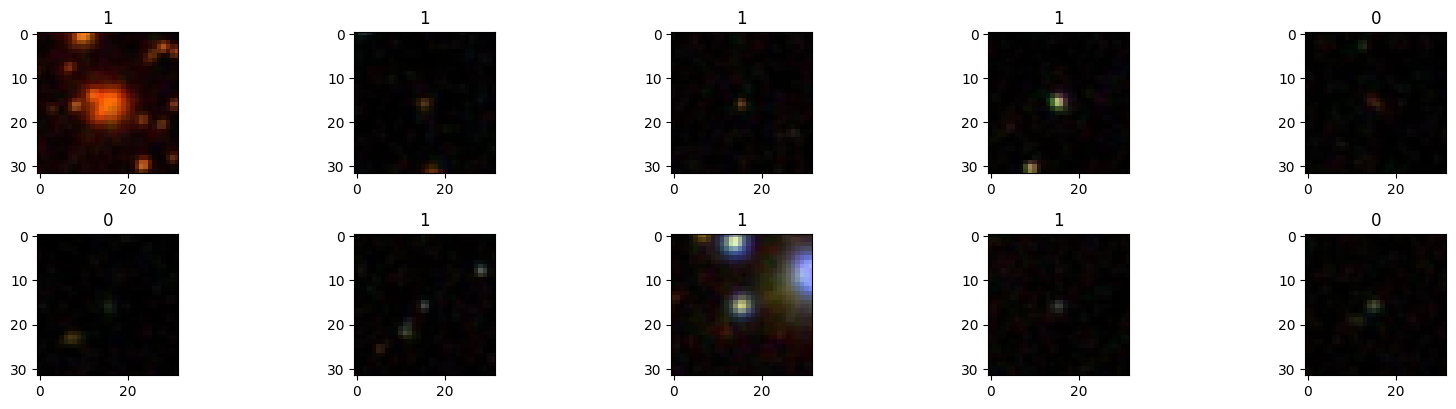

In [11]:
plt.figure(figsize=(16, 8))
for i in range(1, 11):
    plt.subplot(4, 5, i)
    plt.imshow(X_train[i], cmap = 'gray')
    plt.title(y_train[i])
    plt.tight_layout()
plt.show()

In [12]:
# Resize the image to 128x128 with tensorflow
X_train = tf.image.resize(X_train, (32, 32)).numpy()
X_val = tf.image.resize(X_val, (32, 32)).numpy()
# Normalize the image
X_val = X_val / X_val.max()
X_train = X_train / X_train.max()

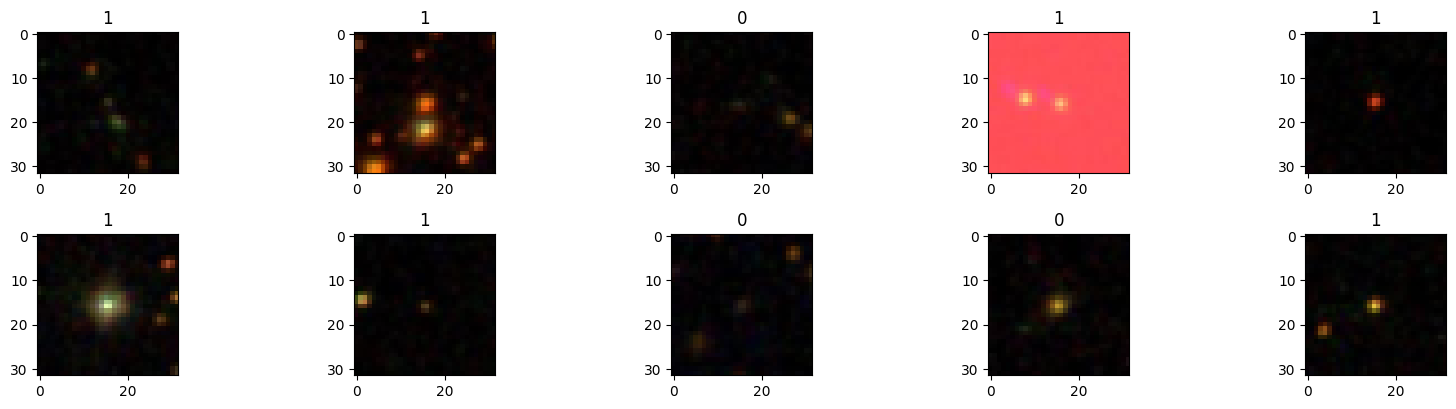

In [13]:
plt.figure(figsize=(16, 8))
for i in range(1, 11):
    plt.subplot(4, 5, i)
    plt.imshow(X_val[i], cmap = 'gray')
    plt.title(y_val[i])
    plt.tight_layout()
plt.show()

In [14]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
    )

datagen.fit(X_train)

## Training

In [15]:
# Define the model
model = Sequential([Conv2D(16, (3,3), activation='relu', input_shape=(32,32,3)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.2),

    Conv2D(32, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
# Compile the model
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer = optimizer, loss='binary_crossentropy', metrics=['accuracy'])
print("Model successfully defined and compiled")

Model successfully defined and compiled


In [17]:
# Train the model with validation data
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    steps_per_epoch=len(X_train) // 8,
    epochs=20,
    batch_size=16,
    validation_data=(X_val, y_val)
)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2339/4680 ━━━━━━━━━━━━━━━━━━━━ 1:11 31ms/step - accuracy: 0.7345 - loss: 0.5901

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


4680/4680 ━━━━━━━━━━━━━━━━━━━━ 81s 17ms/step - accuracy: 0.7581 - loss: 0.5363 - val_accuracy: 0.8375 - val_loss: 0.3530
Epoch 2/20
4680/4680 ━━━━━━━━━━━━━━━━━━━━ 74s 16ms/step - accuracy: 0.8301 - loss: 0.3898 - val_accuracy: 0.8455 - val_loss: 0.3373
Epoch 3/20
4680/4680 ━━━━━━━━━━━━━━━━━━━━ 75s 16ms/step - accuracy: 0.8450 - loss: 0.3623 - val_accuracy: 0.8433 - val_loss: 0.3396
Epoch 4/20
4680/4680 ━━━━━━━━━━━━━━━━━━━━ 80s 16ms/step - accuracy: 0.8535 - loss: 0.3446 - val_accuracy: 0.8515 - val_loss: 0.3274
Epoch 5/20
4680/4680 ━━━━━━━━━━━━━━━━━━━━ 74s 16ms/step - accuracy: 0.8590 - loss: 0.3369 - val_accuracy: 0.8485 - val_loss: 0.3306
Epoch 6/20
4680/4680 ━━━━━━━━━━━━━━━━━━━━ 74s 16ms/step - accuracy: 0.8625 - loss: 0.3295 - val_accuracy: 0.8593 - val_loss: 0.3140
Epoch 7/20
4680/4680 ━━━━━━━━━━━━━━━━━━━━ 82s 16ms/step - accuracy: 0.8634 - loss: 0.3238 - val_accuracy: 0.8563 - val_loss: 0.3200
Epoch 8/20
4680/4680 ━━━━━━━━━━━━━━━━━━━━ 82s 16ms/step - accuracy: 0.8661 - loss: 0.31

In [18]:
# Get the history of the training
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

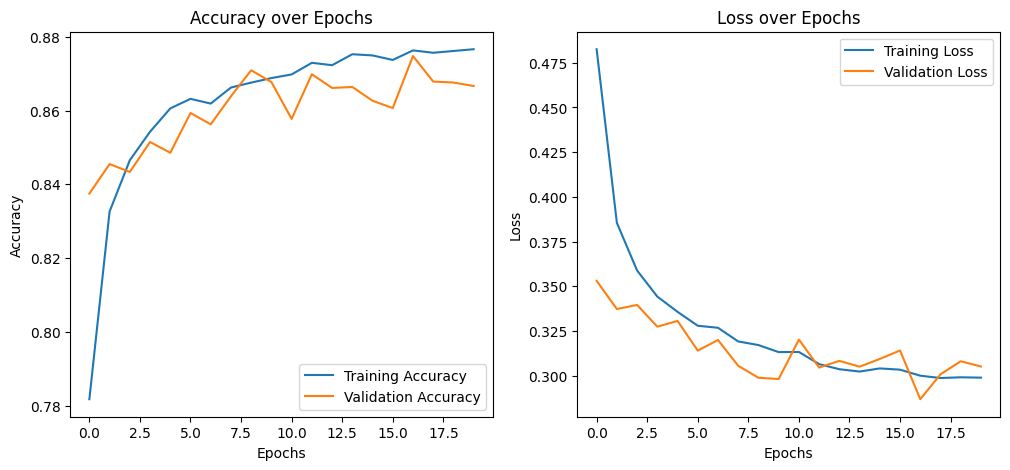

In [19]:
# The curve accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# The curve Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [20]:
# The final Precision
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print(f"Précision finale sur l'ensemble d'entraînement : {final_train_accuracy:.4f}")
print(f"Précision finale sur l'ensemble de validation : {final_val_accuracy:.4f}")

Précision finale sur l'ensemble d'entraînement : 0.8766
Précision finale sur l'ensemble de validation : 0.8667


In [21]:
# Save the model
model.save('Cnn-class-image.h5')
print("Modèle sauvegardé au format HDF5.")

Modèle sauvegardé au format HDF5.


In [22]:
# Charge the model
loaded_model = tf.keras.models.load_model('Cnn-class-image.h5')

In [23]:
image_predictions = loaded_model.predict(X_val)
image_predictions = np.argmax(image_predictions, axis=0)
val_labels = np.argmax(y_val, axis=0)

235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


In [37]:
print(y_val.shape)

print(image_predictions.shape)

(1,)
(7507,)


(7507,)